In [19]:
import pandas as pd
import numpy as np
import pickle
import finEC.datapreproc as dpp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
# %%
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV, train_test_split
from xgboost import XGBRegressor

In [20]:
# loading data

df=pd.read_csv("../data/stock_prices_yahoo.csv",parse_dates=["Date"])

# %%
ec=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec=ec.reset_index()
events=ec[['symbol','date','quarter','year']]
events['date']=pd.to_datetime(events.date)
events.sort_values(['symbol','date'],inplace=True)

# %%
sp500=pd.read_csv("../data/SP500HistoricalData.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500latest=pd.read_csv("../data/HistoricalData_1686903580615.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500=pd.merge(sp500,sp500latest,how="outer",on="Date")

# %%
sp500=sp500[['Date','Price','Close/Last']]
sp500['Price'].fillna(sp500['Close/Last'], inplace=True)
sp500.drop(columns=['Close/Last'],inplace=True)
#rename the columns
sp500.columns=['Date','SP500']
sp500['Date']=pd.to_datetime(sp500.Date)
sp500.sort_values('Date',inplace=True)
sp500['pct_change_sp500'] = sp500['SP500'].pct_change()


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
df1=df.merge(sp500,how="left",on="Date")
df1.info()
df1.Date.min(),df1.Date.max()
df1 = df1.sort_values(['Ticker', 'Date'])
df1['pct_change_close'] = df1.groupby('Ticker')['Close'].pct_change()

pd.options.mode.chained_assignment = None  # default='warn'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44096 entries, 0 to 44095
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        44096 non-null  int64         
 1   index             44096 non-null  int64         
 2   Date              44096 non-null  datetime64[ns]
 3   Open              44096 non-null  float64       
 4   High              44096 non-null  float64       
 5   Low               44096 non-null  float64       
 6   Close             44096 non-null  float64       
 7   Adj Close         44096 non-null  float64       
 8   Volume            44096 non-null  int64         
 9   Ticker            44096 non-null  object        
 10  SP500             44096 non-null  float64       
 11  pct_change_sp500  44096 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 4.4+ MB


In [22]:
# %%
#implementing the event study methodology
#first, we need to create the event window
#we will use the 2 
for ticker in df1.Ticker.unique():
    df=df1[df1.Ticker==ticker]
    event_dates=events[events.symbol==ticker].date.to_list()
        
    # Define the event window
    event_window = 2

    # Initialize a list to store the abnormal returns
    abnormal_returns_pre = []
    abnormal_returns_event = []
    abnormal_returns_post = []
    allCAR1=[]
    allCAR2=[]
    allMAR1=[]
    allMAR2=[]
    pre_event_window = 100
    post_event_window = 30
    # Iterate over the event dates
    for event_date in event_dates:
        # Filter the data within the event window
        event_start = event_date - pd.Timedelta(days=event_window)
        event_end = event_date + pd.Timedelta(days=event_window)
        
        event_data = df[(df['Date'] >= event_start) & (df['Date'] <= event_end)]

        # Filter the data before the event
        pre_event_start = event_start - pd.Timedelta(days=pre_event_window)
        pre_event_data = df[(df['Date'] >= pre_event_start) & (df['Date'] < event_start)]
        #dropna
        pre_event_data.dropna(inplace=True)

        #pead
        post_event_end = event_end + pd.Timedelta(days=post_event_window)
        post_event_data = df[(df['Date'] > event_end) & (df['Date'] <= post_event_end)]
        # Fit the linear regression model using the market model
        X = pre_event_data['pct_change_sp500'].values.reshape(-1, 1)  # Replace 'Market Return' with your market return column
        y = pre_event_data['pct_change_close'].values.reshape(-1, 1)  # Replace 'Stock Return' with your stock return column
        model = LinearRegression()
        model.fit(X, y)

        # Predict stock returns for each day in the event window
        X_event = event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns = model.predict(X_event)

        # Compute abnormal returns for each day in the event window
        actual_returns = event_data['pct_change_close'].values
        abnormal_returns_event.extend(actual_returns - predicted_returns.flatten())
        #compute cumulative abnormal returns
        CAR1 = np.sum(abnormal_returns_event)
        allCAR1.append(CAR1)
        #compute mean abnormal returns
        MAR1 = np.mean(abnormal_returns_event)
        allMAR1.append(MAR1)

        #compute the abnormal returns for the pre event window
        X_pre = pre_event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns_pre = model.predict(X_pre)
        actual_returns_pre = pre_event_data['pct_change_close'].values
        abnormal_returns_pre.extend(actual_returns_pre - predicted_returns_pre.flatten())

        #compute the abnormal returns for the post event window
        X_post = post_event_data['pct_change_sp500'].values.reshape(-1, 1)
        predicted_returns_post = model.predict(X_post)
        actual_returns_post = post_event_data['pct_change_close'].values
        abnormal_returns_post.extend(actual_returns_post - predicted_returns_post.flatten())
        #compute cumulative abnormal returns
        CAR2 = np.sum(abnormal_returns_post)
        allCAR2.append(CAR2)
        #compute mean abnormal returns
        MAR2 = np.mean(abnormal_returns_post)
        allMAR2.append(MAR2)

    events.loc[events.symbol==ticker,'CAR1']=allCAR1
    events.loc[events.symbol==ticker,'CAR2']=allCAR2
    events.loc[events.symbol==ticker,'MAR1']=allMAR1
    events.loc[events.symbol==ticker,'MAR2']=allMAR2
    # join the abnormal returns with the daily stock returns
    # df1[df1.Ticker==ticker][(df1['Date'] >= pre_event_start) & (df1['Date'] <= post_event_end)]['abnormalreturn']=abnormal_returns_pre + abnormal_returns_event+abnormal_returns_post



In [23]:
# creating the relative for the EPS

# %%
# importing the data

df = pd.read_csv('../data/stock_prices_ec.csv',parse_dates=['Date'])

df['eps_surprise'] = (df['eps_mean_report'] / df['eps_mean']) - 1
df=df.merge(events, how='left', left_on=['Ticker', 'Date'], right_on=['symbol', 'date'])

# %%
#adding one hot encoding for the years 2008 and 2020
df['year_2008'] = np.where(df['year'] == 2008, 1, 0)
df['year_2020'] = np.where(df['year'] == 2020, 1, 0)
#adding one hot encoding for the quarters
df['quarter_1'] = np.where(df['quarter'] == 1, 1, 0)
df['quarter_2'] = np.where(df['quarter'] == 2, 1, 0)
df['quarter_3'] = np.where(df['quarter'] == 3, 1, 0)
df['quarter_4'] = np.where(df['quarter'] == 4, 1, 0)
#adding one hot encoding for the different tickers using the get_dummies function
# df=pd.get_dummies(df, columns=['Ticker'], prefix=['Ticker'])

In [24]:


# %%
# defining features
#targets are CAR1, CAR2 cumulative abnormal returns and MAR1,MAR2 mean abnormal returns
#CAR2 is the best target. CAR1 is the cumulative abnormal returns for the event window and CAR2 is the cumulative abnormal returns for the post event window
target = ['CAR2']

identification = ['Date', 'Ticker']
dummies=['Ticker_ABBV', 'Ticker_AZN',
       'Ticker_BMY', 'Ticker_JNJ', 'Ticker_LLY', 'Ticker_MRK', 'Ticker_NVO',
       'Ticker_NVS', 'Ticker_PFE', 'Ticker_ROG']
# dummies=['year_2008','year_2020','quarter_1','quarter_2','quarter_3','quarter_4','Ticker_ABBV', 'Ticker_AZN',
#        'Ticker_BMY', 'Ticker_JNJ', 'Ticker_LLY', 'Ticker_MRK', 'Ticker_NVO',
#        'Ticker_NVS', 'Ticker_PFE', 'Ticker_ROG']
surprise = ['eps_surprise']

technical_features = ['rsi5', 'rsi14', 'rsi50', 'rsi200', 'por_change_1_week_val', 'por_change_1_month_val', 'por_change_1_quater_val', 'por_change_1_year_val']

topic_features = ['t1', 't2', 't3', 't4', 't5', 't6' ] # how much of the topic is there on the document
topic_features_d = ['t1d', 't2d', 't3d', 't4d', 't5d', 't6d'] # how much of the topic is there on the document and in which direction (if it's positive or negative)
topic_features_dg = ['t1dg', 't2dg', 't3dg', 't4dg', 't5dg', 't6dg'] # topic_features_d + if they are talking in the short term or long term




In [25]:
df[topic_features_d].describe()

,t1d,t2d,t3d,t4d,t5d,t6d
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000
mean,0.004659,0.001052,0.001501,0.000790,0.000219,0.000082
std,0.005768,0.002495,0.002794,0.002289,0.000825,0.000485
min,-0.015244,-0.004310,-0.004310,-0.003390,-0.004098,-0.002299
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.003268,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.007173,0.001718,0.002299,0.000000,0.000000,0.000000
max,0.035714,0.035714,0.020270,0.016706,0.006608,0.003922


<Axes: >

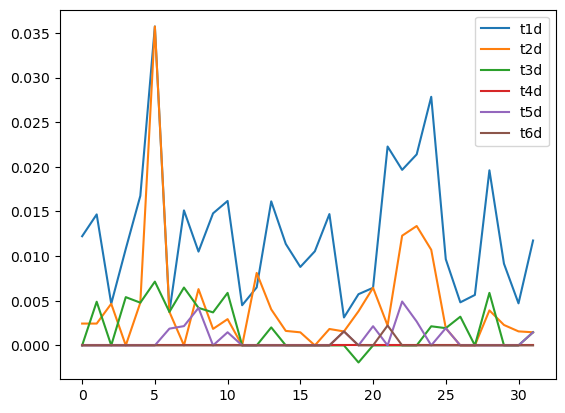

In [30]:
df[df['Ticker']=='ABBV'][topic_features_d].plot()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'CAR2'),
  Text(0, 1.5, 't4d'),
  Text(0, 2.5, 't6d'),
  Text(0, 3.5, 't1d'),
  Text(0, 4.5, 't2d'),
  Text(0, 5.5, 't5d'),
  Text(0, 6.5, 't3d')])

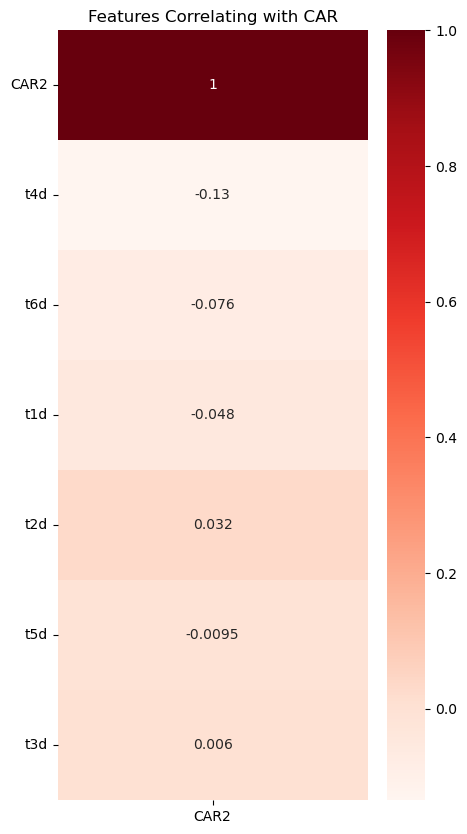

In [33]:
#####################
top_features = df[topic_features_d+['CAR2']].corr()[['CAR2']].sort_values(by='CAR2', key = abs, ascending=False)
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(top_features,
                      annot=True,
                      cmap='Reds')
heatmap.set_title('Features Correlating with CAR')
plt.yticks(rotation=0)

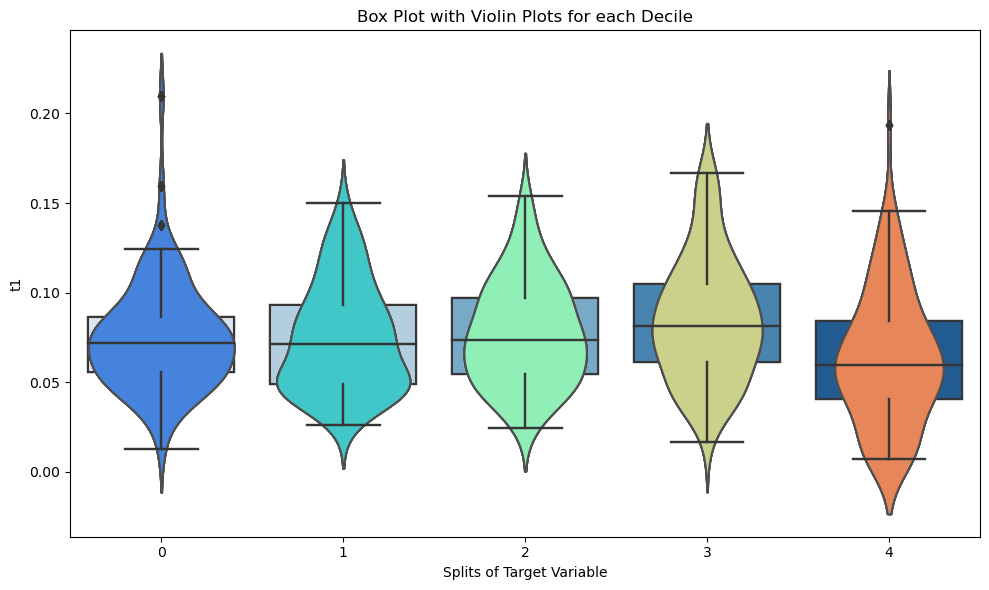

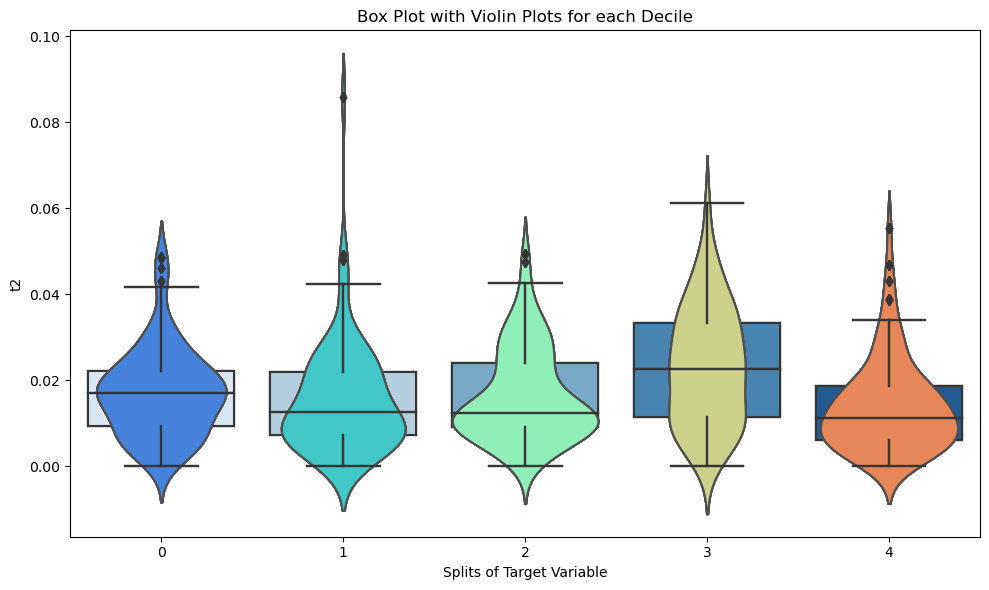

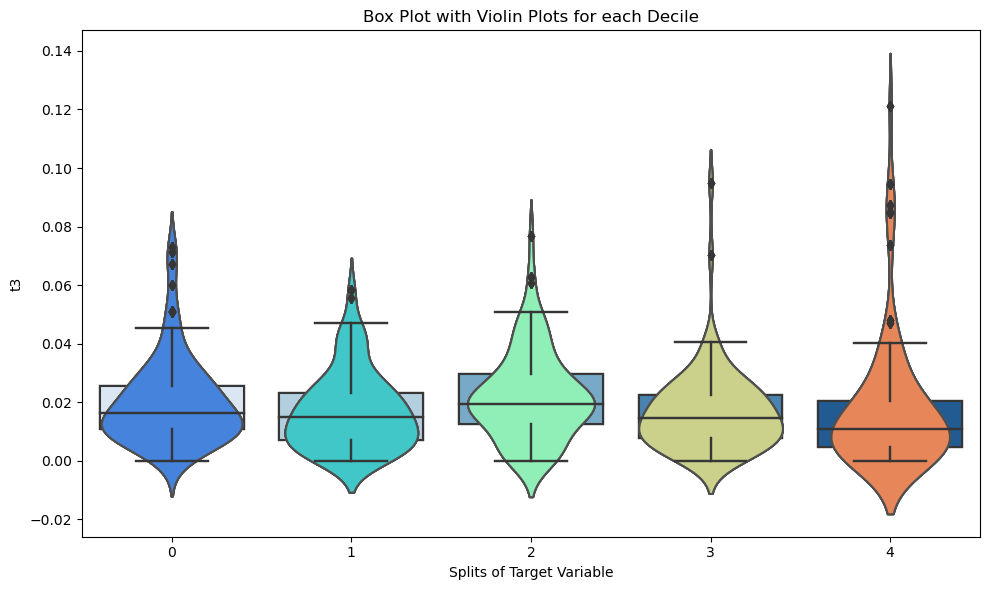

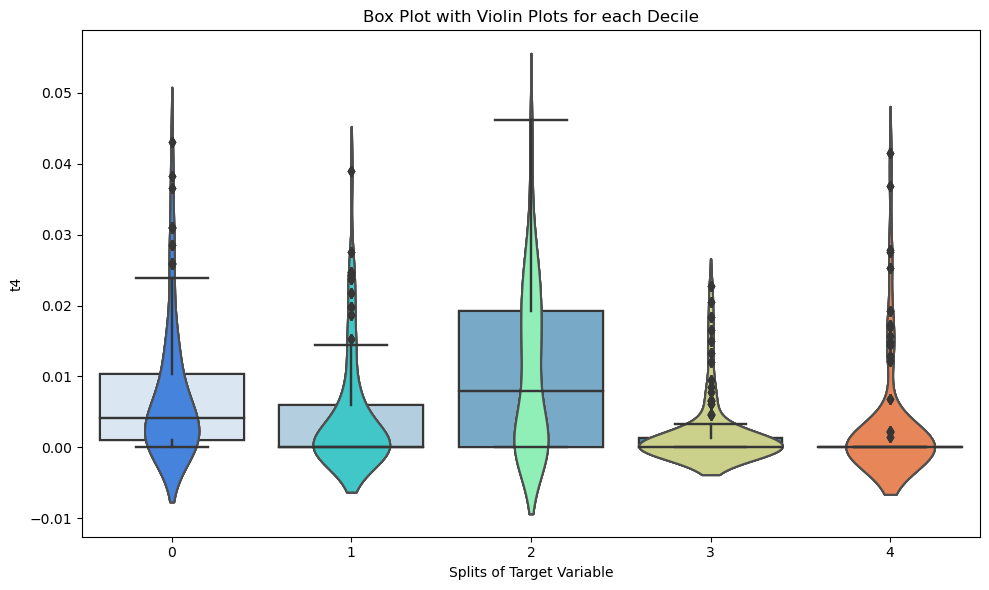

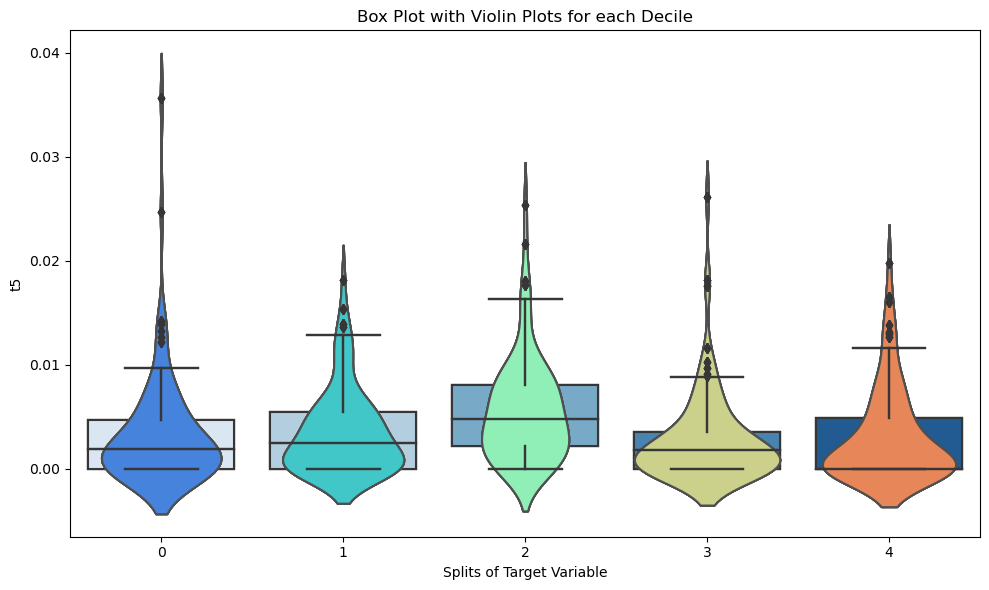

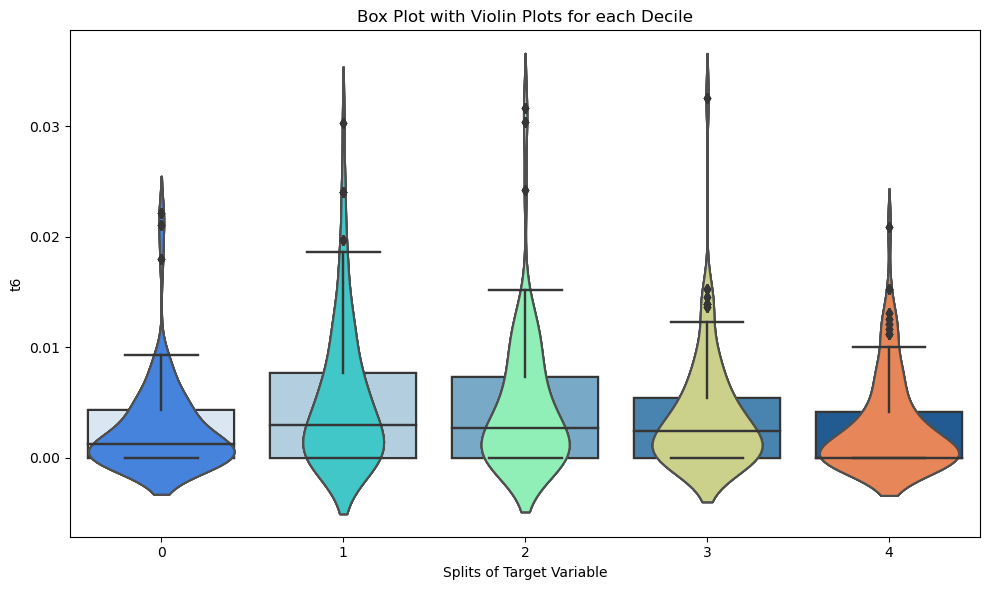

In [60]:
deciles = np.linspace(0, 100, 11)
for t in topic_features:
    # Compute decile bins for the target variable
    df['decile'] = pd.qcut(df['CAR2'], q=5, labels=False)
    df['decilecar1'] = pd.qcut(df['CAR1'], q=5, labels=False)
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(5):
        # plt.subplot(2, 5, i+1)
        sns.boxplot(x='decile', y=f'{t}', data=df, ax=ax, palette='Blues')

        # Create the violin plots
        sns.violinplot(x='decile', y=f'{t}', data=df, ax=ax, inner=None, palette='rainbow')

        # Set the plot title and axis labels
        plt.title('Box Plot with Violin Plots for each Decile')
        plt.xlabel('Splits of Target Variable')
        plt.ylabel(f'{t}')
        # subset = df[df['decile'] == i]
        # plt.boxplot(subset[t])
        # plt.title(f'Split {i+1}')
        # plt.xlabel(f'{t}')
        # plt.ylabel('Value')

    plt.tight_layout()
    plt.show()


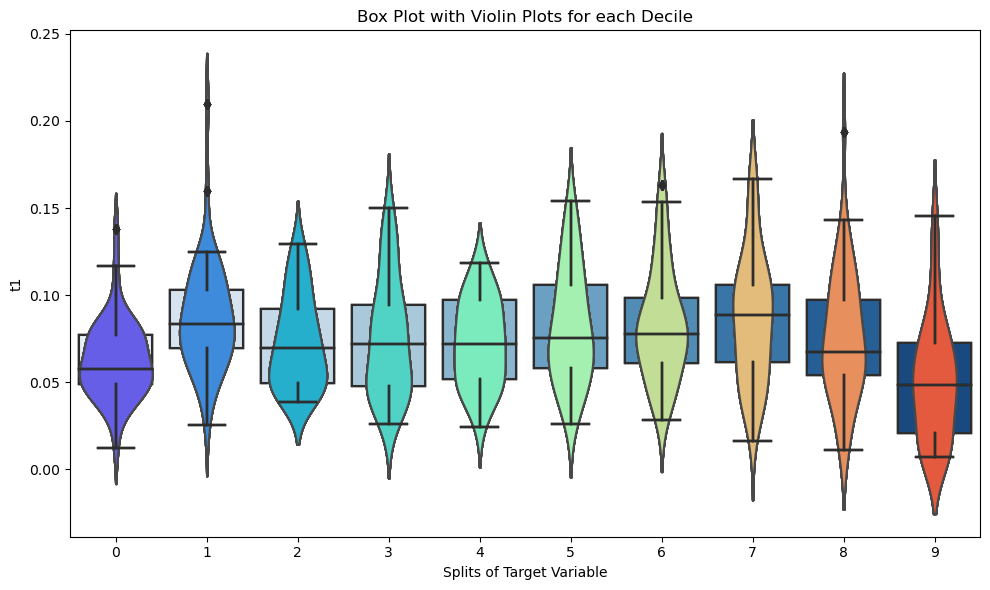

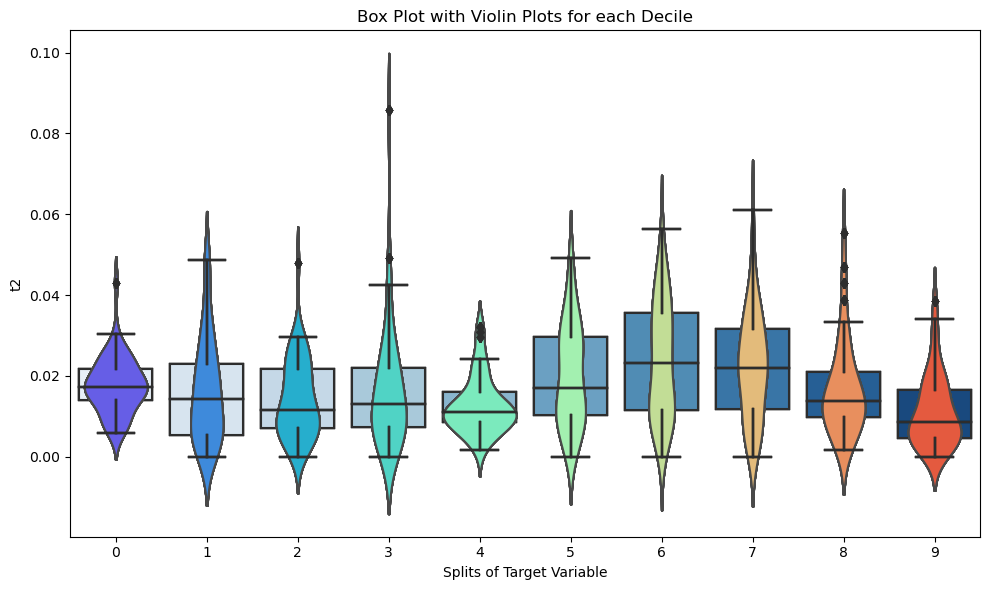

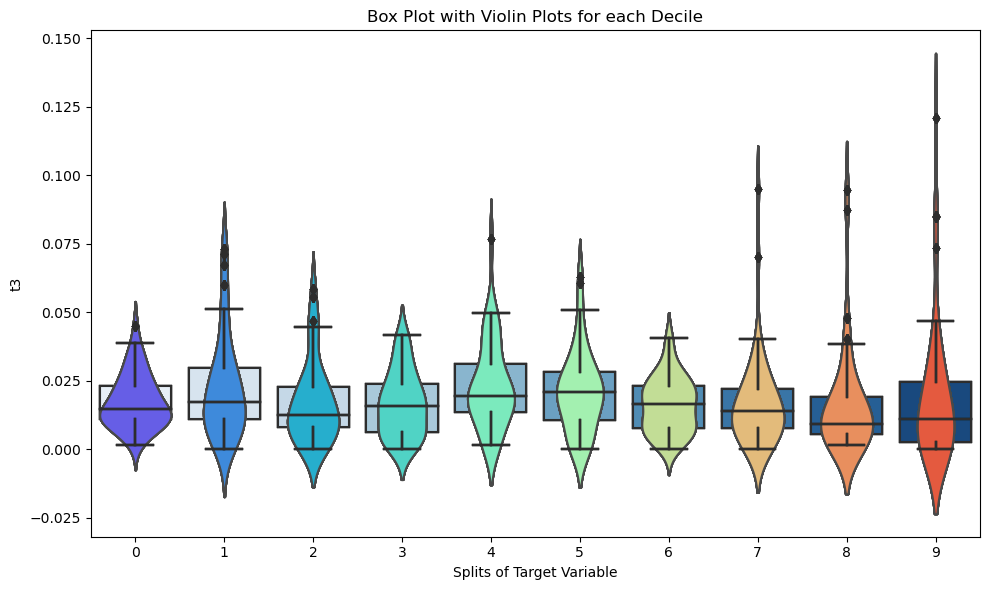

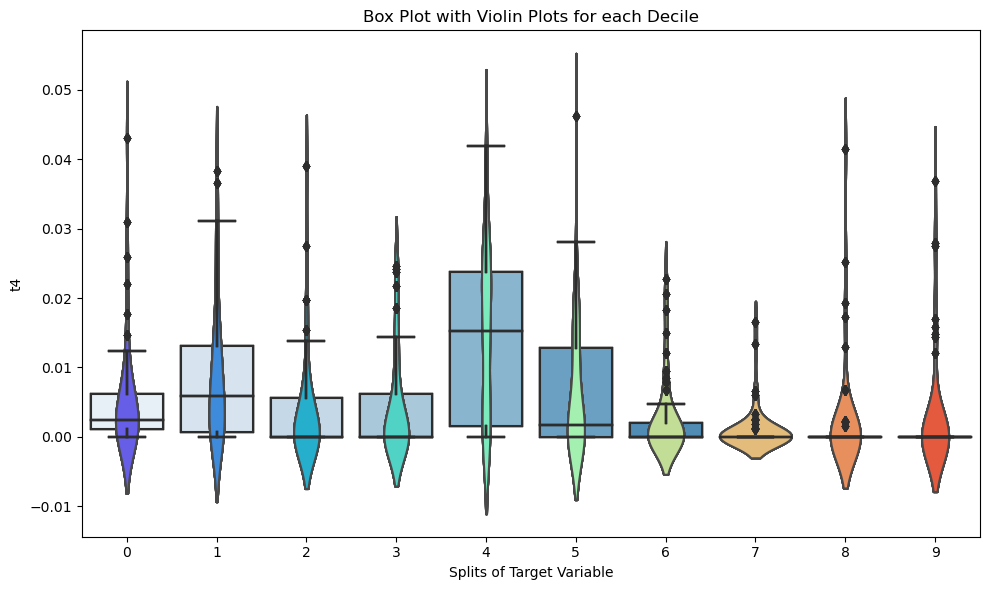

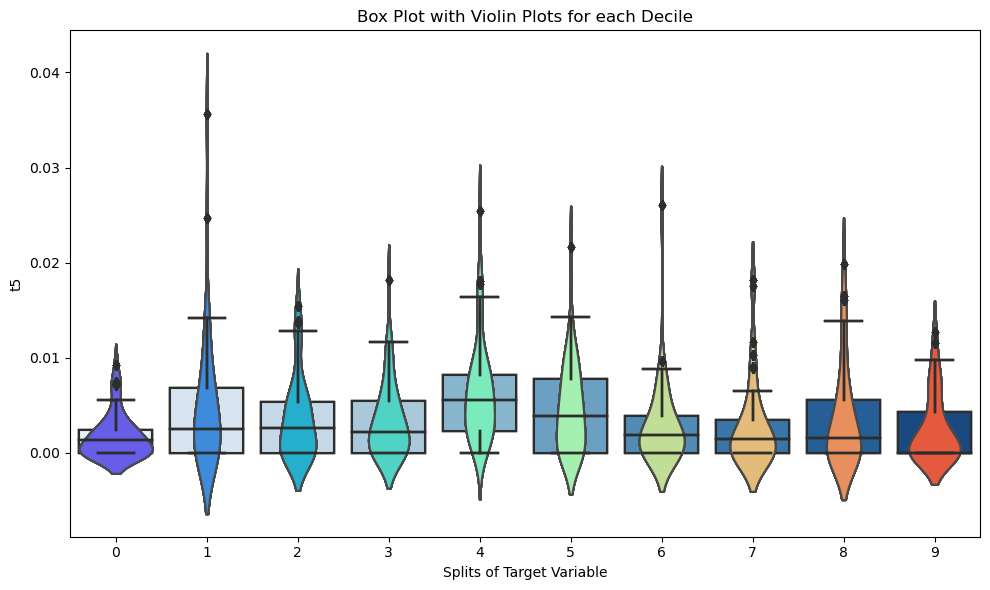

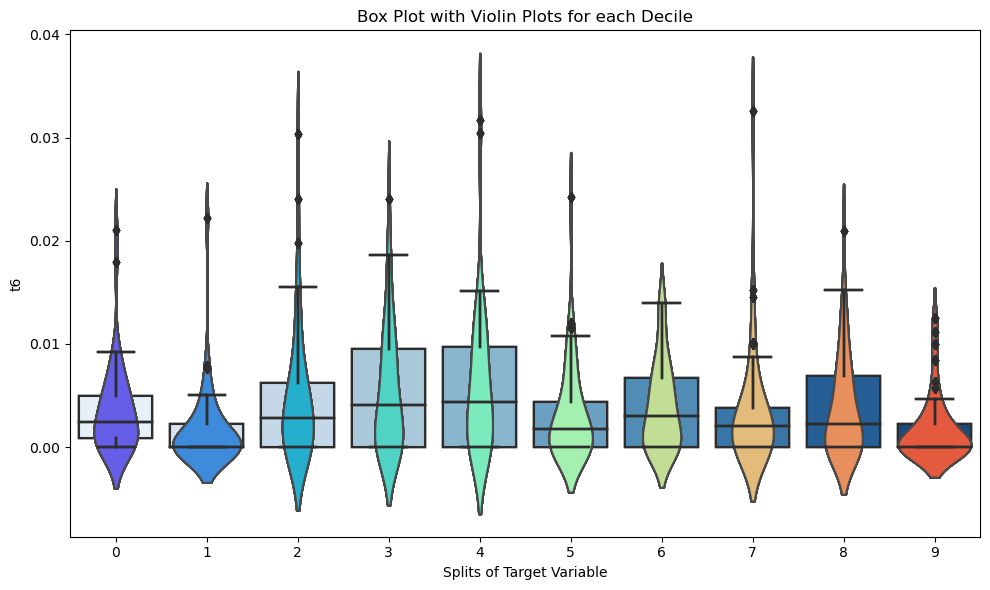

In [72]:
deciles = np.linspace(0, 100, 11)
for t in topic_features:
    # Compute decile bins for the target variable
    df['decile'] = pd.qcut(df['CAR2'], q=10, labels=False)
    df['decilecar1'] = pd.qcut(df['CAR1'], q=5, labels=False)
    df1=df[df['Ticker']=='ABBV']
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(10):
        # plt.subplot(2, 5, i+1)
        sns.boxplot(x='decile', y=f'{t}', data=df, ax=ax, palette='Blues')

        # Create the violin plots
        sns.violinplot(x='decile', y=f'{t}', data=df, ax=ax, inner=None, palette='rainbow')

        # Set the plot title and axis labels
        plt.title('Box Plot with Violin Plots for each Decile')
        plt.xlabel('Splits of Target Variable')
        plt.ylabel(f'{t}')
        # subset = df[df['decile'] == i]
        # plt.boxplot(subset[t])
        # plt.title(f'Split {i+1}')
        # plt.xlabel(f'{t}')
        # plt.ylabel('Value')

    plt.tight_layout()
    plt.show()


<Axes: >

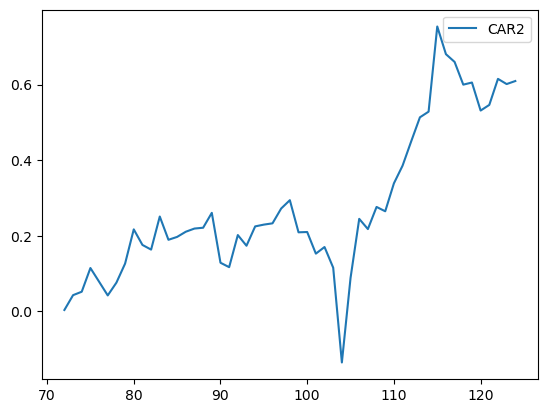

In [57]:
df[df['Ticker']=='BMY'][target].plot()

In [48]:
df['deciles'] = pd.qcut(df['CAR2'], q=10, labels=False)

In [47]:
df[df['CAR2']==df['CAR2'].max()]

,Unnamed: 0,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,content,10d_close_pct,10d_future_close,10d_future_close_pct,ma5,ma14,ma50,ma200,rsi5,rsi14,rsi50,rsi200,por_change_1_week_val,por_change_1_month_val,por_change_1_quater_val,por_change_1_year_val,ma_5days_1month,ma_10days_1quarter,ma_20days_1year,eps_mean_report_pdif,topic0,topic1,topic2,topic4,topic5,topic3,t1,t2,t3,t4,t5,t6,t1d,t2d,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg,eps_surprise,symbol,date,quarter,year,CAR1,CAR2,MAR1,MAR2,year_2008,year_2020,quarter_1,quarter_2,quarter_3,quarter_4,decile
115,115,2019-07-25,40.403683,33799300.0,BMY,4.2175,3.82,300.0,"Operator: Good day, and welcome to the Bristol...",0.030647,40.2257,-0.000883,38.762615,39.4864,40.733756,43.134606,67.263452,46.402393,49.813447,44.206537,3.064702,1.96415,-1.351946,-19.550579,-2.382153,0.267714,-16.331658,-9.425015,0.0,0.0,0.32179,0.287392,0.389361,0.0,0.013333,0.006667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003333,0.0,0.0,0.0,0.0,0.0,-0.09425,BMY,2019-07-25,2,2019,-0.155443,0.753704,-0.000814,0.000754,0,0,0,1,0,0,4


In [62]:
dataset_cosine=pd.read_csv("../data/dataset_cosine.csv",parse_dates=['Date'])

In [65]:
dfwcs=df.merge(dataset_cosine,how="left",on=["Date","Ticker"])

In [69]:
dfwcs.columns.values

array(['Unnamed: 0_x', 'Date', 'Adj Close_x', 'Volume_x', 'Ticker',
       'eps_mean_x', 'eps_mean_report_x', 'sp_500_closeprice_x',
       'content_x', '10d_close_pct_x', '10d_future_close_x',
       '10d_future_close_pct_x', 'ma5_x', 'ma14_x', 'ma50_x', 'ma200_x',
       'rsi5_x', 'rsi14_x', 'rsi50_x', 'rsi200_x',
       'por_change_1_week_val_x', 'por_change_1_month_val_x',
       'por_change_1_quater_val_x', 'por_change_1_year_val_x',
       'ma_5days_1month_x', 'ma_10days_1quarter_x', 'ma_20days_1year_x',
       'eps_mean_report_pdif_x', 'topic0_x', 'topic1_x', 'topic2_x',
       'topic4_x', 'topic5_x', 'topic3_x', 't1', 't2', 't3', 't4', 't5',
       't6', 't1d', 't2d', 't3d', 't4d', 't5d', 't6d', 't1dg', 't2dg',
       't3dg', 't4dg', 't5dg', 't6dg', 'eps_surprise', 'symbol_x',
       'date_x', 'quarter_x', 'year_x', 'CAR1', 'CAR2', 'MAR1', 'MAR2',
       'year_2008', 'year_2020', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'decile', 'deciles', 'decilecar1', 'Unna

In [70]:
newtopics=['topic11', 'topic12', 'topic3_y', 'topic5_y', 'topic6', 'topic9',
       'topic2_y', 'topic10', 'topic15', 'topic8', 'topic0_y', 'topic13',
       'topic7', 'topic4_y', 'topic1_y', 'topic14']

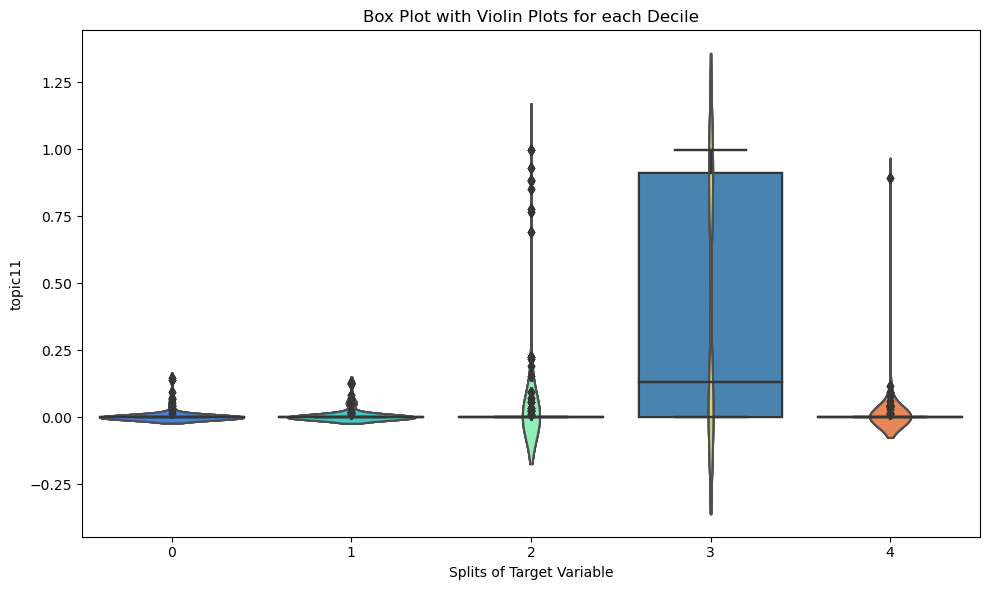

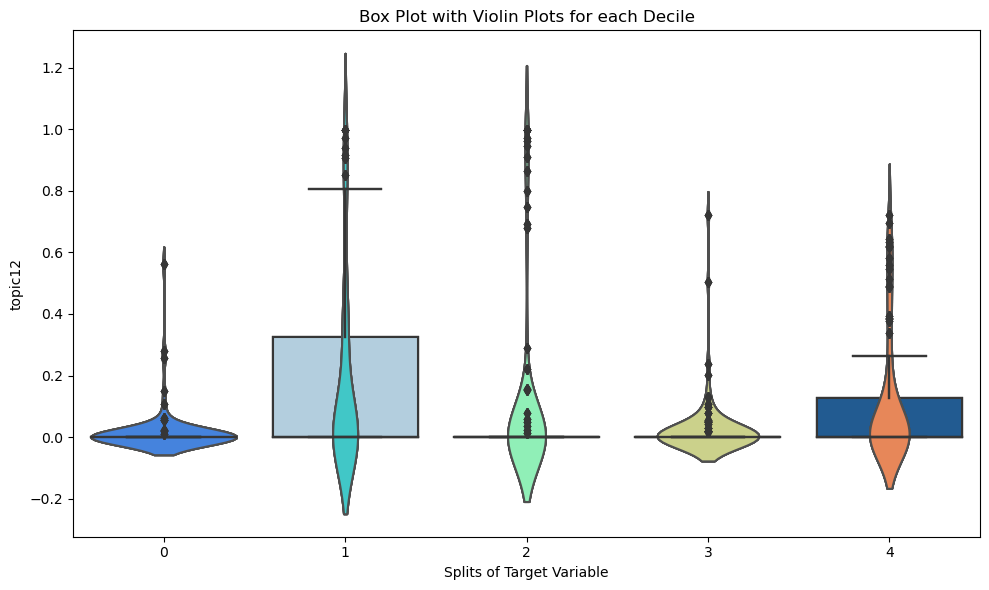

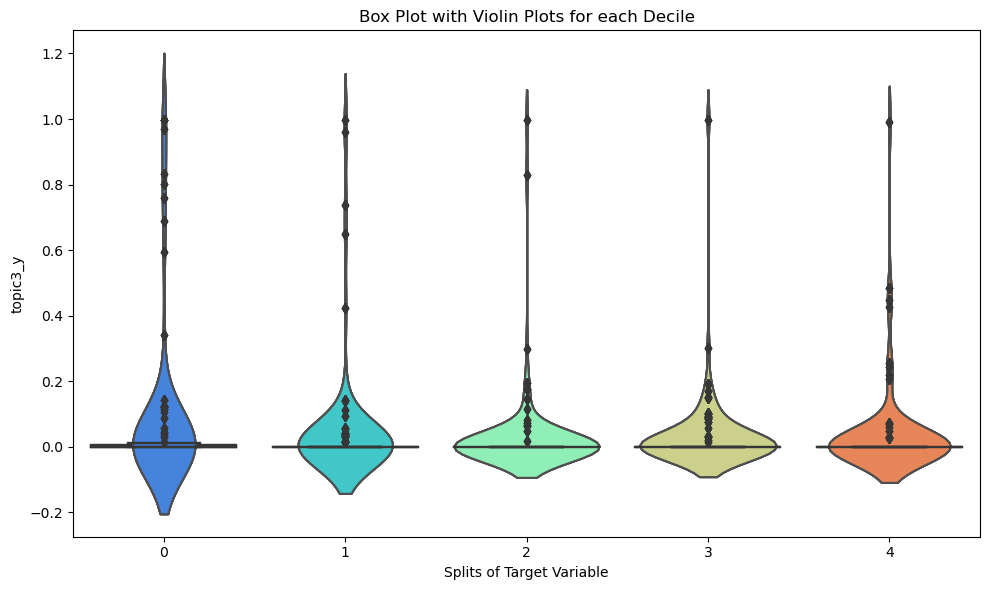

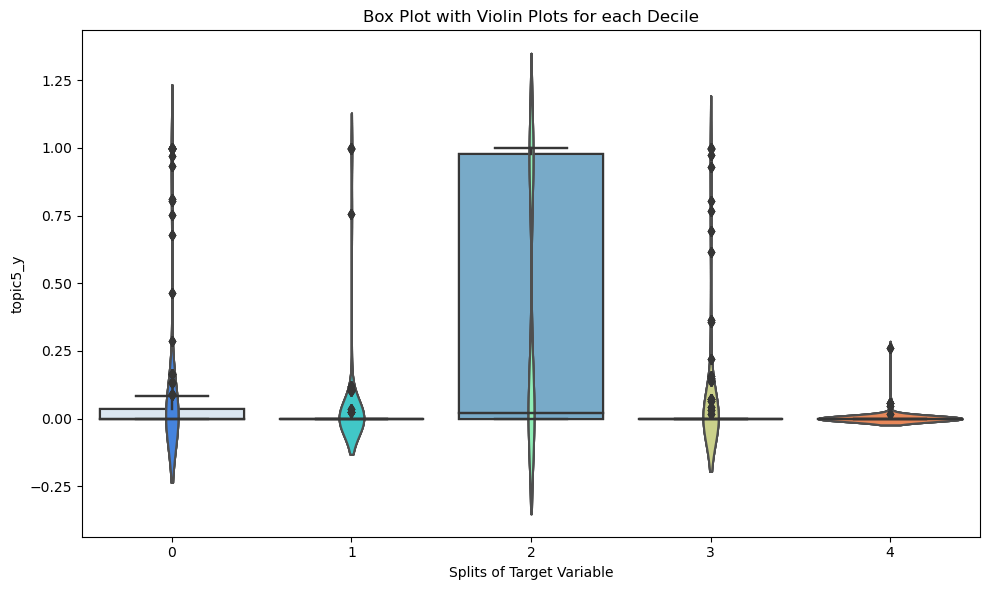

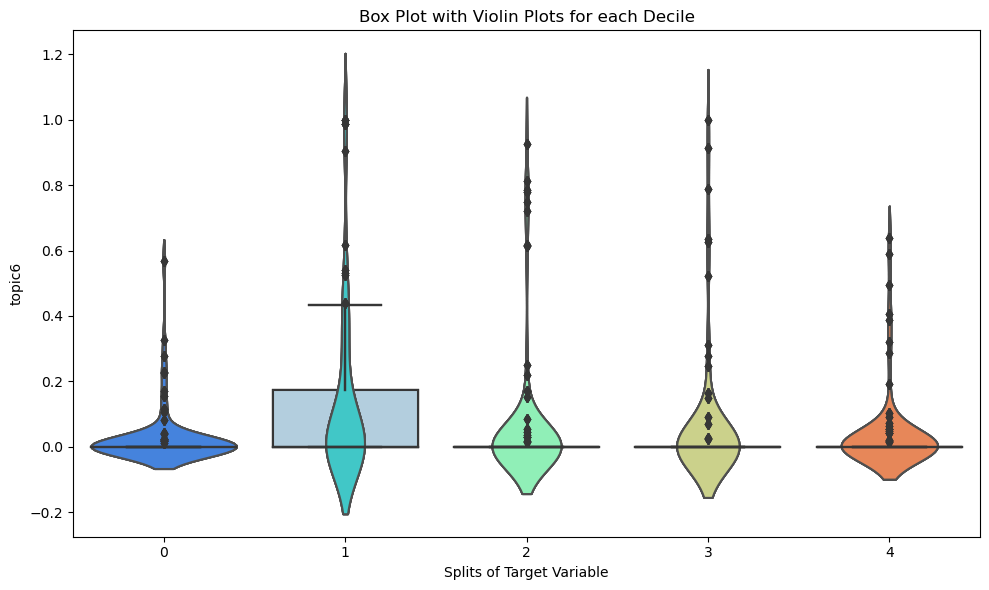

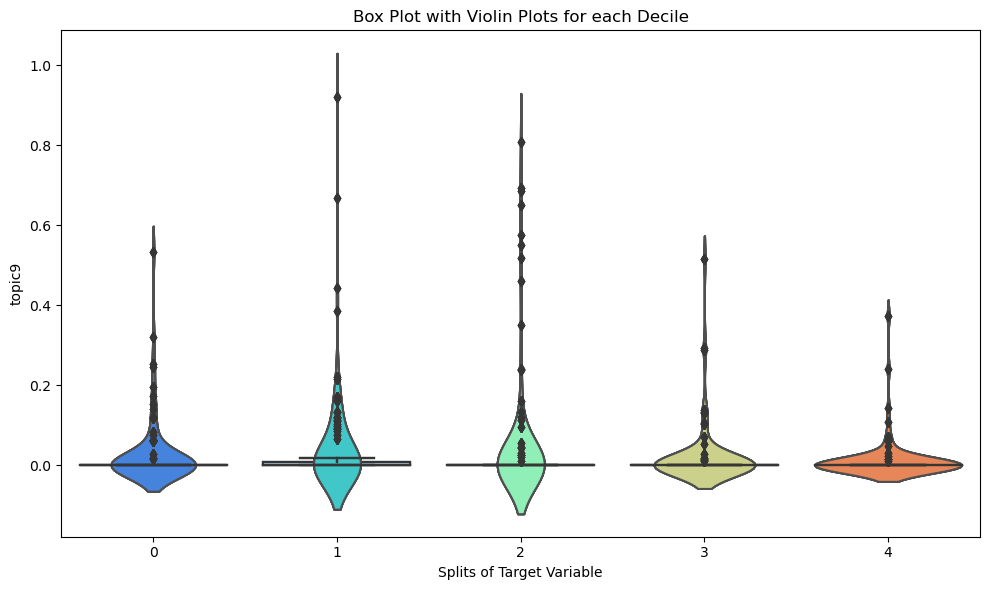

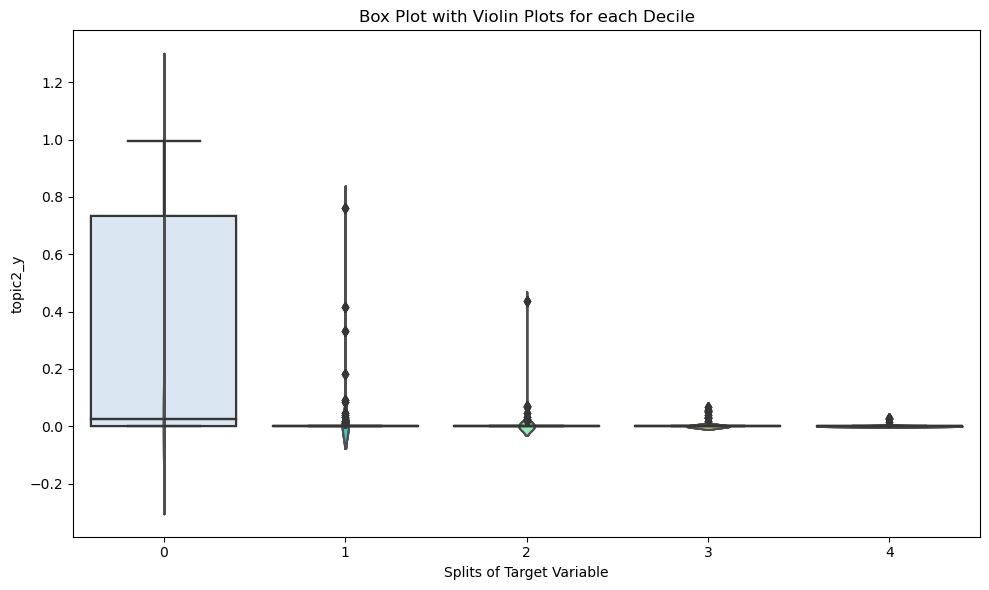

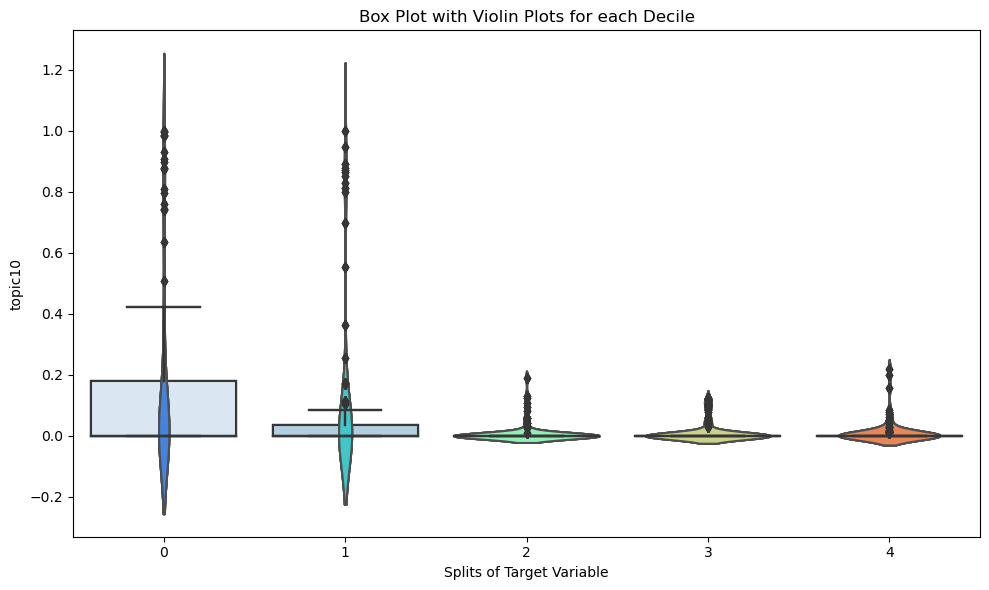

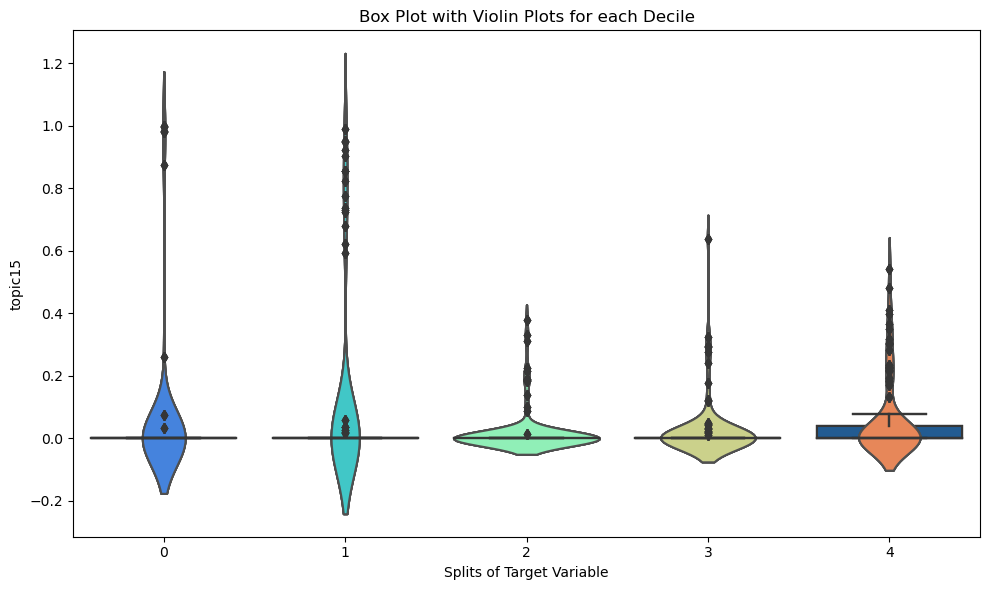

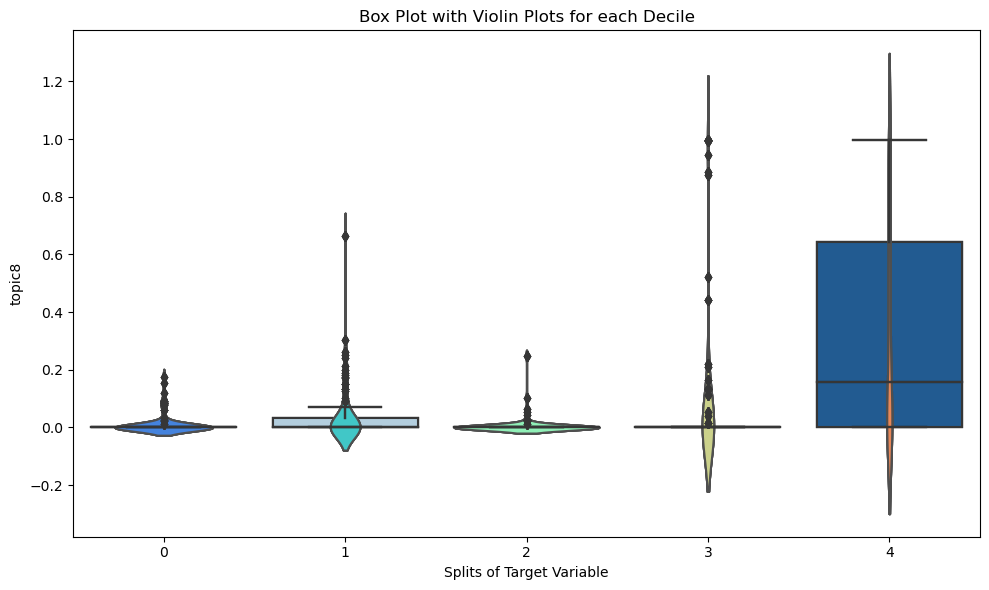

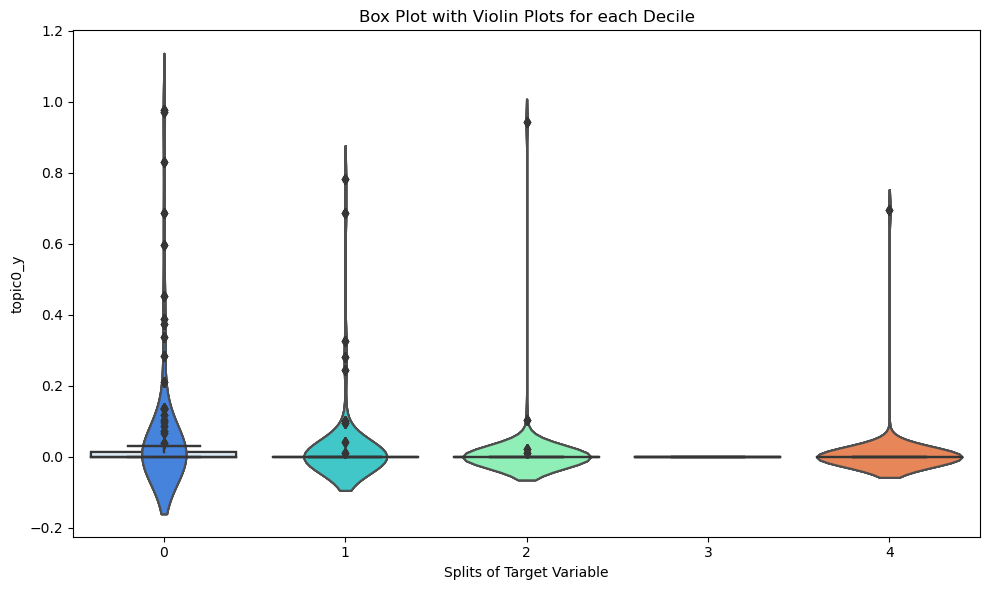

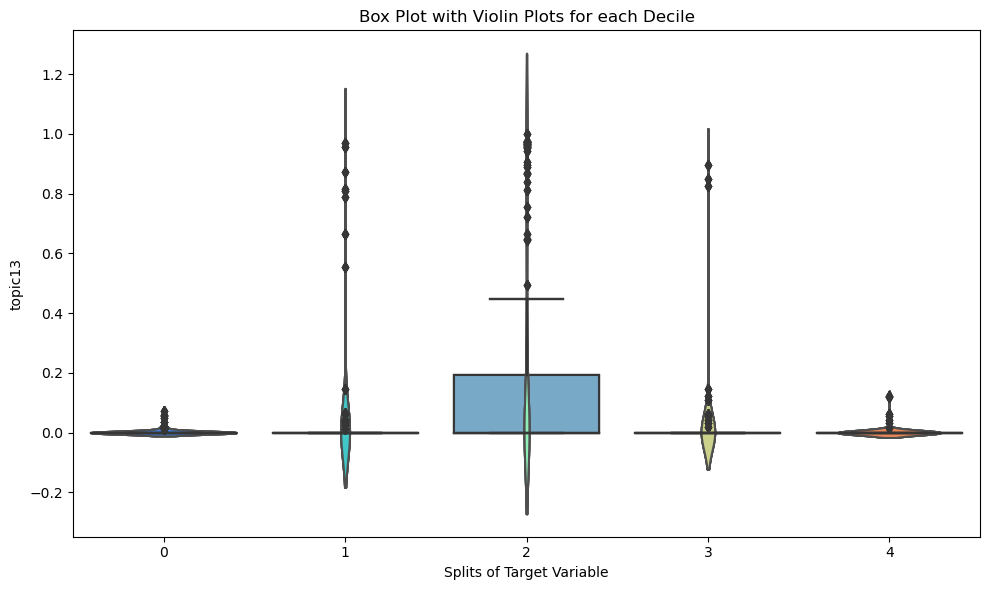

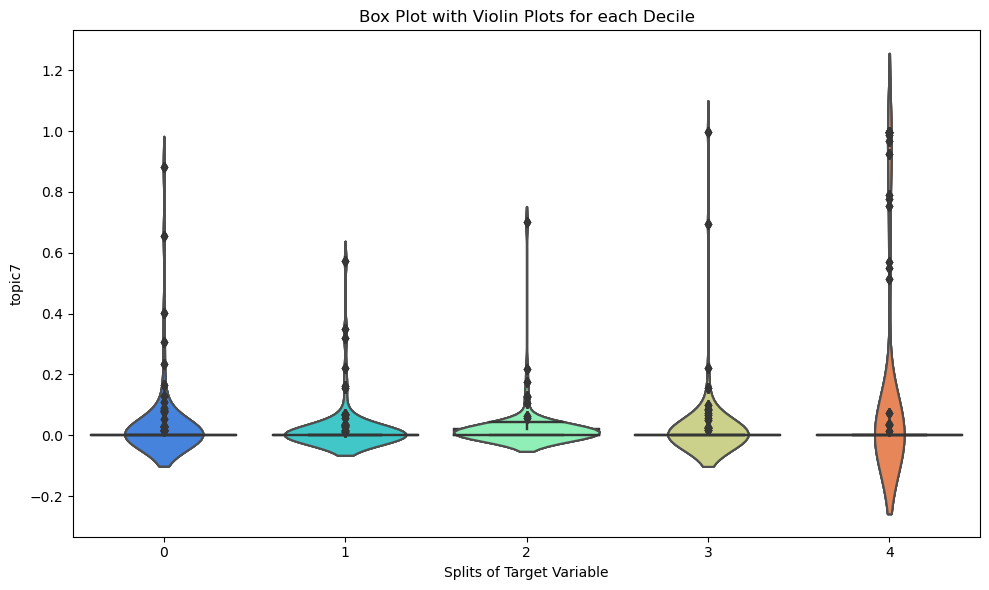

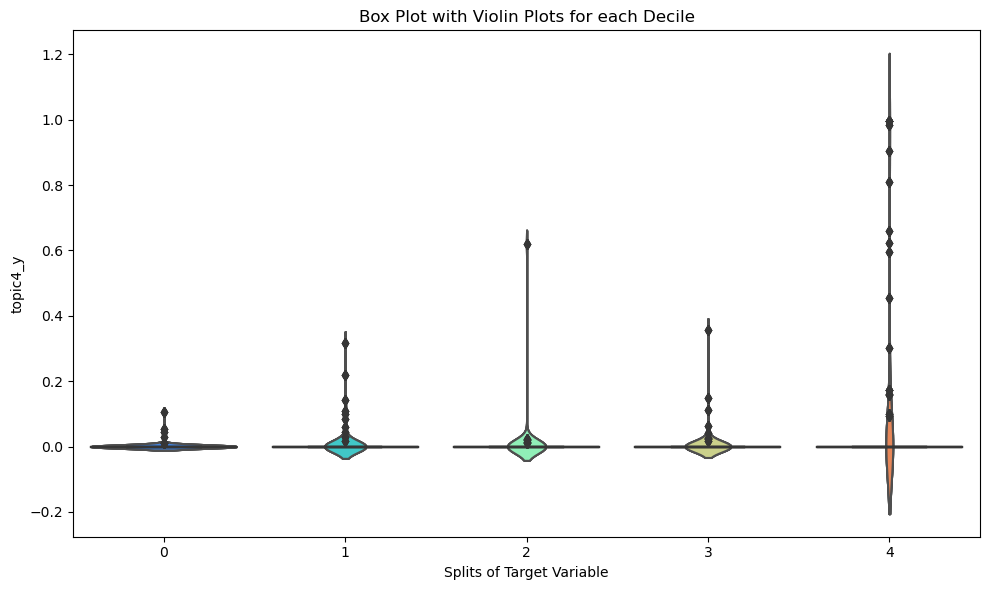

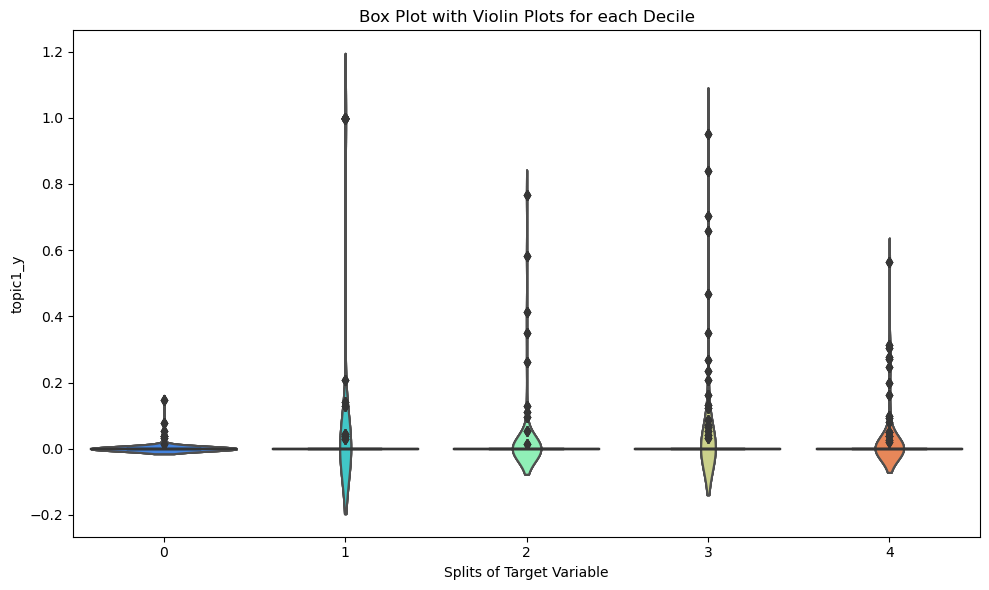

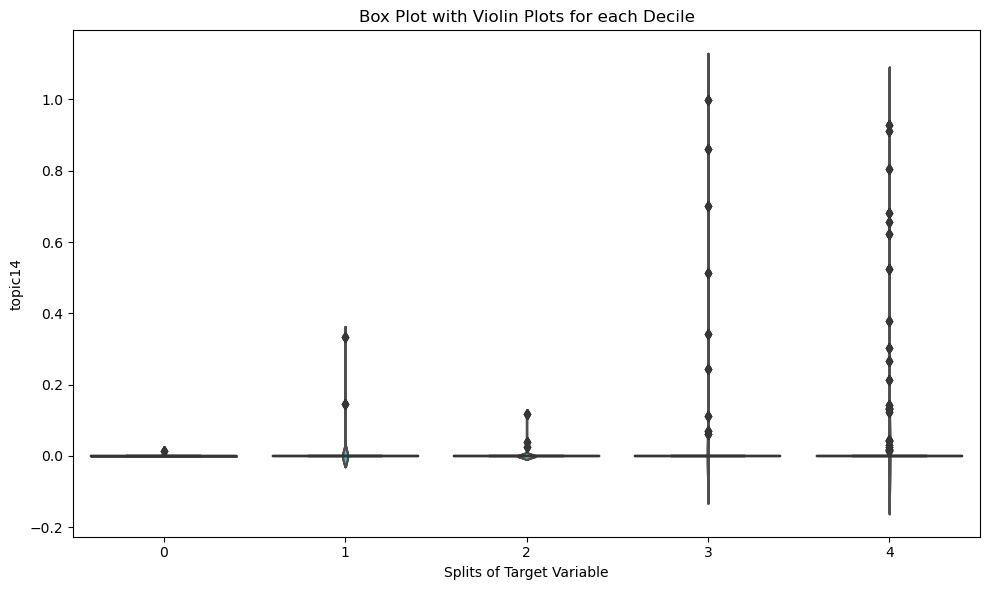

In [71]:
deciles = np.linspace(0, 100, 11)
for t in newtopics:
    # Compute decile bins for the target variable
    df['decile'] = pd.qcut(df['CAR2'], q=5, labels=False)
    df['decilecar1'] = pd.qcut(df['CAR1'], q=5, labels=False)
    # df1=df[df['Ticker']=='ABBV']
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(5):
        # plt.subplot(2, 5, i+1)
        sns.boxplot(x='decile', y=f'{t}', data=dfwcs, ax=ax, palette='Blues')

        # Create the violin plots
        sns.violinplot(x='decile', y=f'{t}', data=dfwcs, ax=ax, inner=None, palette='rainbow')

        # Set the plot title and axis labels
        plt.title('Box Plot with Violin Plots for each Decile')
        plt.xlabel('Splits of Target Variable')
        plt.ylabel(f'{t}')
        # subset = df[df['decile'] == i]
        # plt.boxplot(subset[t])
        # plt.title(f'Split {i+1}')
        # plt.xlabel(f'{t}')
        # plt.ylabel('Value')

    plt.tight_layout()
    plt.show()
